In [1]:
!pip install transformers
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 24.3 MB/s 
     |████████████████████████████████| 7.6 MB 18.9 MB/s 
     |████████████████████████████████| 182 kB 7.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.4 MB/s 
     |████████████████████████████████| 212 kB 61.4 MB/s 
     |████████████████████████████████| 115 kB 70.8 MB/s 
     |████████████████████████████████| 451 kB 64.2 MB/s 
     |████████████████████████████████| 127 kB 59.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# New Section

In [2]:
import csv
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

topics = []
contents = []
labels = []

with open('/content/drive/MyDrive/ECE1786/project/IEL.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile)
    for i, row in enumerate(spamreader):
        if i != 0:
          topics.append(row[0])
          contents.append(row[1])
          labels.append(row[2])


print(len(topics))
print(len(contents))
print(len(labels))



4004
4004
4004


In [3]:
!nvidia-smi

Sun Dec  4 18:36:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
classes = {
    '<4': 0,
    '4.0': 1,
    '4.5': 2,
    '5.0': 3,
    '5.5': 4,
    '6.0': 5,
    '6.5': 6,
    '7.0': 7,
    '7.5': 8,
    '8.0': 9,
    '8.5': 10,
    '9.0': 11
}

scores = [3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9]

from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")

tokenizer.pad_token = tokenizer.eos_token

class GPT2Dataset(Dataset):

  def __init__(self, topics, contents, labels, tokenizer, max_length=512):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []
    self.labels = []

    for i in range(len(topics)):
      input = topics[i].strip() + " " + contents[i].strip()
      encodings_dict = self.tokenizer(input, truncation=True, max_length=max_length, padding="max_length")
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      if labels[i] != "<4":
        self.labels.append(classes[str(float(labels[i]))])
      else:
        self.labels.append(classes[labels[i]])
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.labels[idx], self.attn_masks[idx]
batch_size = 2
dataset = GPT2Dataset(topics, contents, labels, tokenizer)

In [6]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

torch.manual_seed(0)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

## make sure 
print(torch.sum(train_dataset[0][0]))

tensor(5779971)


In [7]:
from transformers import AutoModelForSequenceClassification
torch.manual_seed(0)

model = AutoModelForSequenceClassification.from_pretrained("gpt2-medium", num_labels=12)
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5)

from transformers import get_scheduler

num_epochs = 13
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
torch.manual_seed(0)
from tqdm.auto import tqdm
import evaluate
progress_bar = tqdm(range(num_training_steps))

model.config.pad_token_id = tokenizer.pad_token_id


train_accs = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    metric = evaluate.load("accuracy")
    for input, targets, attn_masks in train_dataloader:
        x = {
              "input_ids": input,
              "labels": targets,
              "attention_mask": attn_masks
        }
        
        batch = {k: v.to(device) for k, v in x.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_acc = metric.compute()['accuracy']
    train_accs.append(train_acc)
    
    print("Epoch: {}, Train acc: {}".format(epoch + 1, train_acc))
    torch.save(model.state_dict(), "/content/drive/MyDrive/ECE1786/project/gpt2_{}.pt".format(epoch))

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/ECE1786/project/gpt2_7.pt"))

<All keys matched successfully>

In [8]:
import evaluate
val_distance = []
val_accs = []
for i in range(10):
  model.load_state_dict(torch.load("/content/drive/MyDrive/ECE1786/project/gpt2_{}.pt".format(i)))

  model.eval()
  model.config.pad_token_id = tokenizer.pad_token_id

  metric = evaluate.load("accuracy")
  total = 0
  distance = 0
  for input, targets, attn_masks in validation_dataloader:
      x = {
          "input_ids": input,
          "labels": targets,
          "attention_mask": attn_masks
      }
      batch = {k: v.to(device) for k, v in x.items()}
      outputs = model(**batch)

      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])
      for j in range(len(predictions)):
        distance += abs(scores[predictions[j]] - scores[targets[j]])
      total += len(predictions)
  distance = distance / total
  # print(distance)
  val_distance.append(distance)
  val_acc = metric.compute()['accuracy']
  val_accs.append(val_acc)
  print(distance, val_acc)

1.4069912609238453 0.2484394506866417
1.2734082397003745 0.24469413233458176
0.8957553058676654 0.3333333333333333
0.7946317103620475 0.365792759051186
0.7640449438202247 0.3408239700374532
0.795880149812734 0.3433208489388265
0.7846441947565543 0.3732833957553059
0.6991260923845194 0.3757802746566791
0.6560549313358303 0.41198501872659177
0.7265917602996255 0.3782771535580524


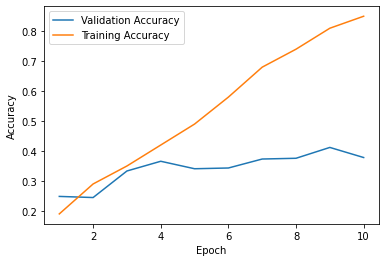

In [ ]:
import matplotlib.pyplot as plt


plt.plot(range(1, 11), val_accs, label='Validation Accuracy')
plt.plot(range(1, 11), [0.19, 0.29, 0.35, 0.42, 0.49, 0.58, 0.68, 0.74, 0.81, 0.85], label='Training Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()